<a href="https://colab.research.google.com/github/vinitjethwa369/Amazon-Reviews-Sentiments-Analysis/blob/main/Amazon_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS =   set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data =pd.read_csv("/content/amazon_alexa.tsv" , delimiter='\t', quoting = 3)
print(f"Dataset Shape: {data.shape}")
print(f"Dataset Columns: {data.columns})")

Dataset Shape: (3150, 5)
Dataset Columns: Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object'))


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
data.dropna(inplace=True)

In [10]:
data['length'] = data['verified_reviews'].apply(len)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
print(f"'verified_reviews' column val : {data.iloc[10]['verified_reviews']}")
print(f"Length of Review : {len(str(data.iloc[10]['verified_reviews']))}")
print(f"Length column val: {data.iloc[10]['length']}")

'verified_reviews' column val : "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of Review : 65
Length column val: 65


We can see the Lenth of review is same as the length conlum for the record

Data Types of the Features

In [13]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


**Analyze the Rating Column**

In [14]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


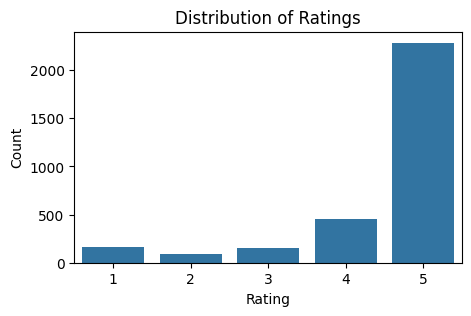

In [15]:
# prompt: create bar chart to visualize the rating clomun

# Bar chart to visualize the rating column
plt.figure(figsize=(5,3))
sns.countplot(x='rating', data=data)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


In [16]:
data['rating'].value_counts()/data.shape[0]*100

,count
rating,
5,72.594474
4,14.449031
1,5.112734
3,4.826929
2,3.016831


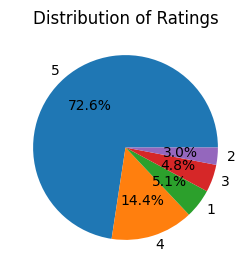

In [17]:
# prompt: create pie chart of rating colmn

# Pie chart to visualize the rating column
plt.figure(figsize=(3,3))
data['rating'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.ylabel('')
plt.show()


**Analyzing the Feedbak Column**

In [18]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [19]:
data['feedback'].value_counts()/data.shape[0]*100

,count
feedback,
1,91.870435
0,8.129565


In [20]:
review_0 = data[data['feedback'] == 0 ].iloc[1]['verified_reviews']
print(review_0)
review_1 = data[data['feedback'] == 1 ].iloc[1]['verified_reviews']
print(review_1)

Sound is terrible if u want good music too get a bose
Loved it!


0 == Neagative FB ||
1 == Positve FB

In [21]:
# Feedback = 0
data[data['feedback']== 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [22]:
# Feedback = 0
data[data['feedback']== 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


if review of rating is 1 or 2 then FB is 0 (negative) and if thw rating is 3, 4 or 5 then the feedback is 1 (positive)

**Analyzing the 'Vatiation' Column**

In [23]:
data['variation'].value_counts()

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


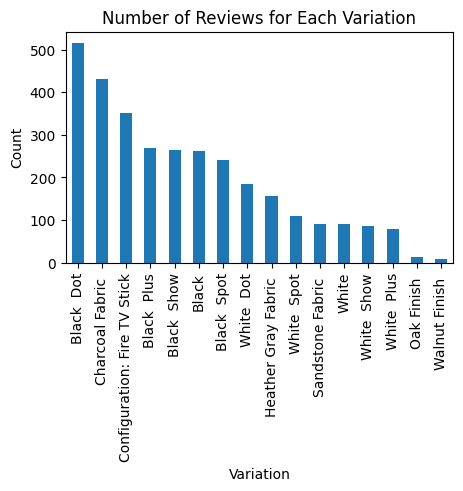

In [24]:
# prompt: form the bar higghest to lowest graph of the variation value count

# Bar chart of variation counts sorted from highest to lowest
plt.figure(figsize=(5,3))
data['variation'].value_counts().plot(kind='bar')
plt.title('Number of Reviews for Each Variation')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()


In [25]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


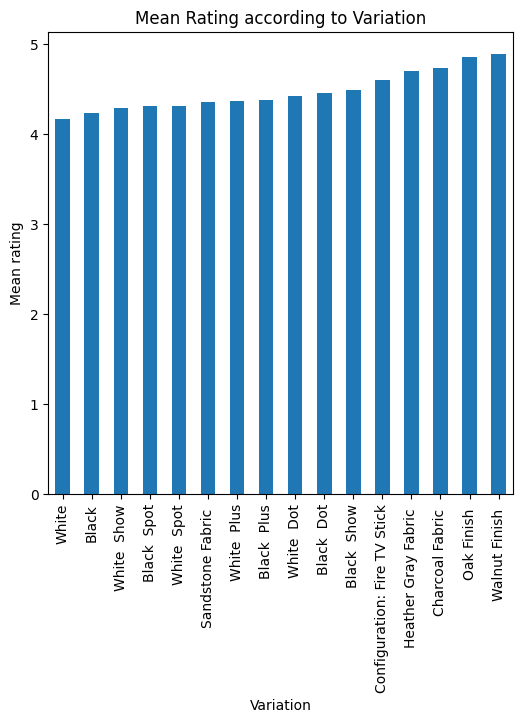

In [26]:
# Bar chart of variation counts sorted from highest to lowest
plt.figure(figsize=(6,6))
data.groupby('variation')['rating'].mean().sort_values().plot(kind='bar')
plt.title('Mean Rating according to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

Walnut Finish has Highest Rating and White has the lowest rating according to the data

**Analyzing the Verified_Reviews Column**

In [27]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


Length Analysis for Full Data Set

[Text(0.5, 1.0, 'Distribution of Length of Review')]

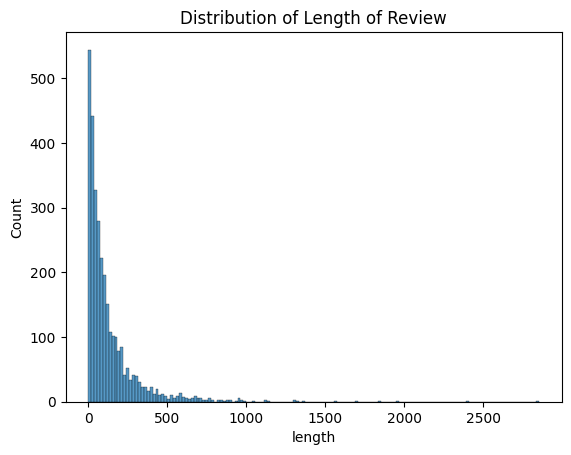

In [28]:
sns.histplot(data['length']).set(title ='Distribution of Length of Review')

Length Analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of Length of Review if Feedback = 0')]

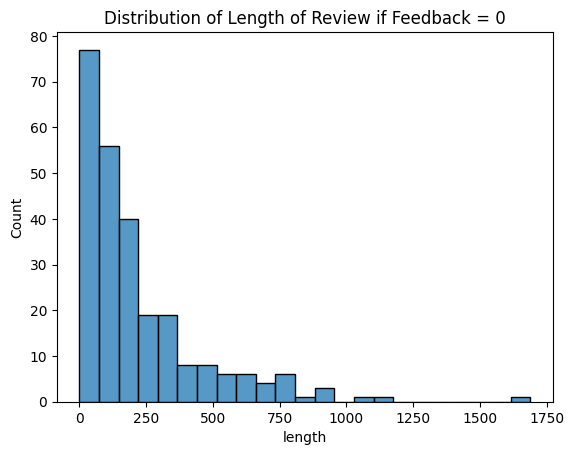

In [29]:
sns.histplot(data[data['feedback']==0]['length']).set(title ='Distribution of Length of Review if Feedback = 0')

Length Analysis when feedback is 1(Positive)

[Text(0.5, 1.0, 'Distribution of Length of Review if Feedback = 1')]

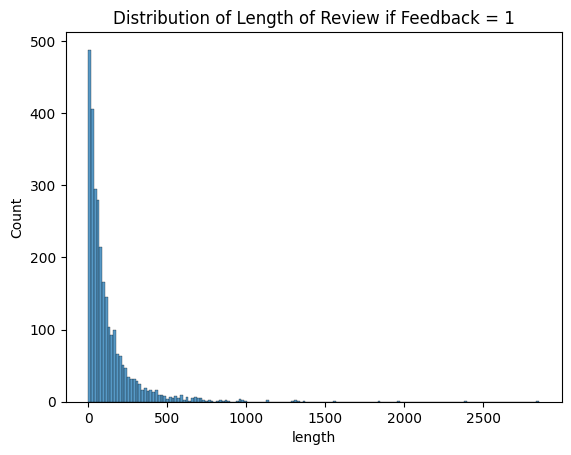

In [30]:
sns.histplot(data[data['feedback']==1]['length']).set(title ='Distribution of Length of Review if Feedback = 1')

Length Mean rating

Text(0, 0.5, 'Length')

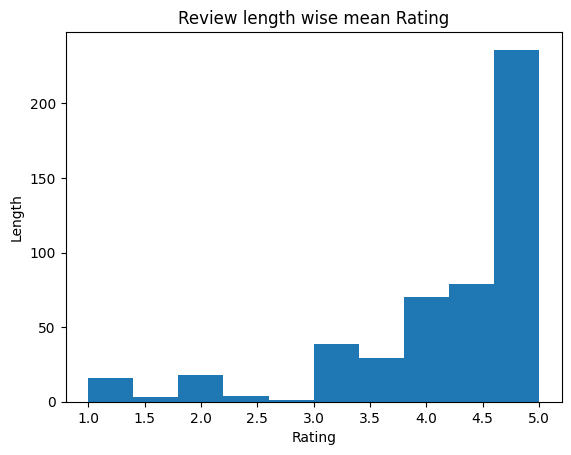

In [31]:
data.groupby('length')['rating'].mean().plot.hist()
plt.title('Review length wise mean Rating')
plt.xlabel('Rating')
plt.ylabel('Length')

People who are giving more rating are writing the large good reviews so length for 5 stars is higher

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

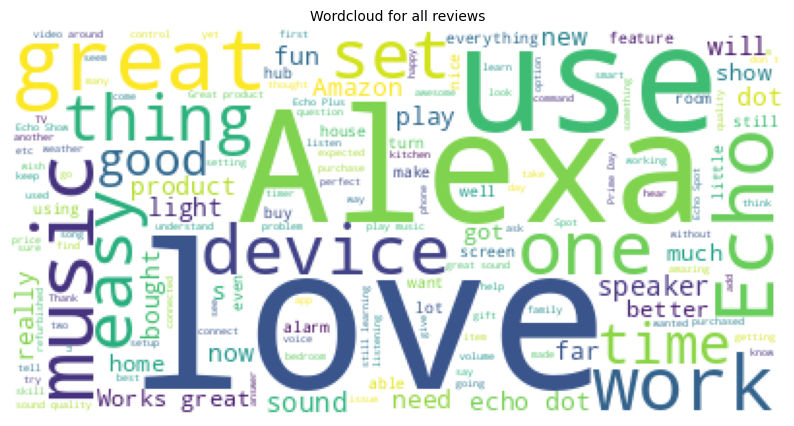

In [33]:
reviews = " ".join([review for review in data['verified_reviews']]) # Remove extra spaces in column name

wc = WordCloud(background_color='white', max_words=500)

plt.figure(figsize=(10,8))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [34]:
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']]) # Remove extra spaces in column name
neg_reviews = neg_reviews.lower().split()


pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']]) # Remove extra spaces in column name
pos_reviews = pos_reviews.lower().split()

unique_neagtive = [x for x in neg_reviews if x not in pos_reviews]
unique_neagtive = " ".join(unique_neagtive)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

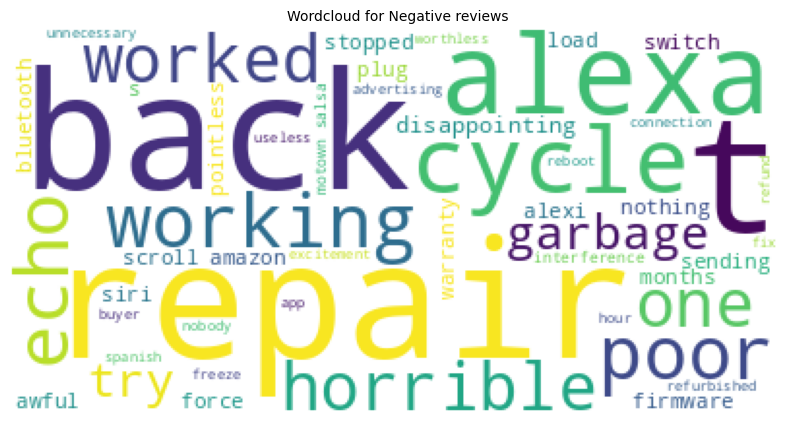

In [35]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,8))
plt.imshow(wc.generate(unique_neagtive))
plt.title('Wordcloud for Negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Neagative words can be seen : horrible, repair, back, echo, cycle,garbage, pointless, refund,

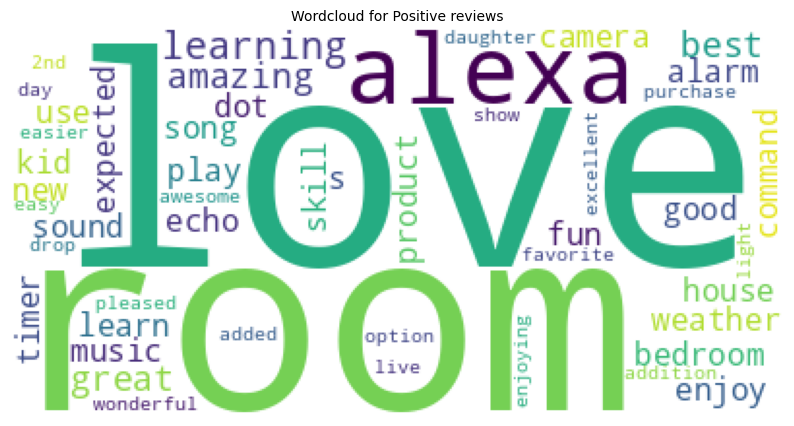

In [36]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,8))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for Positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen :Love, Learning, Expected, Awesome, great, skill, alarm

# **Preprocessing and Modelling**

To build the corpus from the 'verified_reviews' we perfrom the following -

1. Replace any non alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the Infividual words and if it is not a stopwords then add the stemmed from of the words to the corpus

In [37]:
corpus= []
stemmer = PorterStemmer()
for i in range (0,data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to creat bags of words

- Count vectorizer ; technique using in NLP to convert the textual language into the numeric data for feeding to the ML models

In [38]:
cv = CountVectorizer(max_features=2500)

# Storting independent and dependent variable in x and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [39]:
# Saving the count vectorizer

pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

Spliting data into train and test set with 30% data with testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print("X_train:" , X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (2204, 2500)
X_test: (945, 2500)
y_train: (2204,)
y_test: (945,)


In [41]:
print("X train max val:", X_train.max())
print("X test max val:", X_test.max())

X train max val: 12
X test max val: 10


Will scale X_train and X_test so that all values are between 0 & 1

In [42]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [43]:
# Saving the Scaler model

pickle.dump(scaler, open('scaler.pkl', 'wb'))

**Random Forest**

In [44]:
# fitting scaled x_train and y_train to Random forest classifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

print("Training Accuracy of RF :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy of RF :", model_rf.score(X_test_scl, y_test))

Training Accuracy of RF : 0.9945553539019963
Testing Accuracy of RF : 0.944973544973545


In [45]:
from xgboost import XGBClassifier # Correct class name

model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

print("Training Accuracy of XGB :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy of XGB :", model_xgb.score(X_test_scl, y_test))

Training Accuracy of XGB : 0.971415607985481
Testing Accuracy of XGB : 0.9417989417989417


In [46]:
# Now predict using the rescaled X_test
y_pred = model_xgb.predict(X_test_scl)

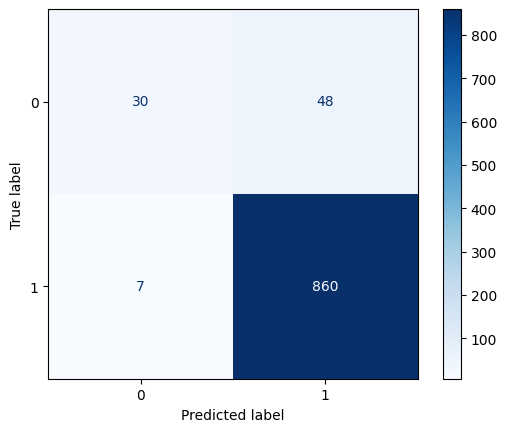

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels `y_true` and predicted labels `y_pred`
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()


In [48]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 30  48]
 [  7 860]]


* True Negatives (TN): 30 (Top-left cell) - The number of negative instances that were correctly classified as negative.
* False Positives (FP): 48 (Top-right cell) - The number of negative instances that were incorrectly classified as positive.
* False Negatives (FN): 7 (Bottom-left cell) - The number of positive instances that were incorrectly classified as negative.
* True Positives (TP): 860 (Bottom-right cell) - The number of positive instances that were correctly classified as positive.

In [49]:
# Values from the confusion matrix
TN = 30
FP = 48
FN = 7
TP = 860

# Calculating the metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.94
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Specificity: 0.38


In [50]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [52]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
with open('countVectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

new_review = "I bought this product as a gift for my sister, and she was absolutely delighted with it. She’s mentioned several times how much it has improved her daily routine. It’s been a hit with everyone who’s seen it."
new_review_vectorized = vectorizer.transform([new_review])
sentiment = model_xgb.predict(new_review_vectorized)

if sentiment == 1 :
  print(f"The sentiment of the review is: Positive")

elif sentiment == 0:
  print(f"The sentiment of the review is: Negative")

else :
  print(f"The sentiment of the review is: Neutral")

The sentiment of the review is: Positive
